[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/open-atmos/PyPartMC/blob/main/examples/additive_coag_comparison.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyPartMC/blob/main/examples/additive_coag_comparison.ipynb)    
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyPartMC.git/main?urlpath=lab/tree/examples/additive_coag_comparison.ipynb)

In [1]:
# This file is a part of PyPartMC licensed under the GNU General Public License v3
# Copyright (C) 2023 University of Illinois Urbana-Champaign
# Authors:
#  - https://github.com/compdyn/partmc/graphs/contributors
#  - https://github.com/open-atmos/PyPartMC/graphs/contributors

In [2]:
import sys

if "google.colab" in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyPartMC')

In [3]:
import urllib
import json
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils import show_plot
from open_atmos_jupyter_utils.show_anim import show_anim 
import PySDM as pysdm
from PySDM import environments
from PySDM.initialisation import spectra
from PySDM.dynamics.collisions import collision_kernels
from PySDM import products
import PyPartMC as ppmc

In [4]:
N_PART = 2**16
VOLUME_M3 = 1e6
DT_SEC = 1.
T_MAX_SEC = 3600
NUM_CONC_PER_M3 = 2**23
DIAM_AT_MEAN_VOL_M = 2*30.531e-6
ADDITIVE_KERNEL_COEFF = 1000
AMBIENT_T_K = 288
AMBIENT_P_Pa = 1e5
AMBIENT_RH = 0.999

# Plotting parameters
N_BINS = 128
N_BIN_EDGES = N_BINS + 1
R_BINS_MIN = 1e-5
R_BINS_MAX = 5e-3
PLOT_TIME_STEP = 120 # seconds
BINNING_METHOD = 'Mass Density (g/m^3 dlnr)' # 'Number Concentration (m^-3)' or 'Mass Density (g/m^3 dlnr)'


In [5]:
radius_bins_edges=np.logspace(np.log10(R_BINS_MIN), np.log10(R_BINS_MAX), num=N_BIN_EDGES, endpoint=True)


builder = pysdm.Builder(
    N_PART,
    backend=pysdm.backends.CPU(),
    environment=environments.Box(dt=DT_SEC * pysdm.physics.si.s, 
                                 dv=VOLUME_M3 * pysdm.physics.si.m**3)
)
trivia = builder.formulae.trivia
spectrum = spectra.Exponential(
    norm_factor=NUM_CONC_PER_M3 *VOLUME_M3 / pysdm.physics.si.m**3, #TODO: check
    scale=trivia.volume(radius=DIAM_AT_MEAN_VOL_M / 2 * pysdm.physics.si.m)
)
builder.add_dynamic(pysdm.dynamics.Coalescence(
    collision_kernel=collision_kernels.Golovin(b=ADDITIVE_KERNEL_COEFF)
))
if BINNING_METHOD == 'Number Concentration (m^-3)':
    binning = (products.ParticleSizeSpectrumPerVolume(
            radius_bins_edges=radius_bins_edges,
            name='spectrum',),)
elif BINNING_METHOD == 'Mass Density (g/m^3 dlnr)':
    binning = (products.ParticleVolumeVersusRadiusLogarithmSpectrum(
            radius_bins_edges=radius_bins_edges,
            name='spectrum',),)

particulator = builder.build(
    attributes=builder.particulator.environment.init_attributes(
        spectral_discretisation=pysdm.initialisation.sampling.spectral_sampling.Logarithmic(
            spectrum,
        )
    ),
    products=binning
)
# print(np.amax(particulator.attributes["multiplicity"].to_ndarray()))
particulator.environment["rhod"] = 1. # TODO!
pysdm_output = {}
for step in range(int(T_MAX_SEC // PLOT_TIME_STEP)+1):
    if step != 0:
        particulator.run(int(PLOT_TIME_STEP // DT_SEC))
    if BINNING_METHOD == 'Number Concentration (m^-3)':
        pysdm_output[step] = particulator.products['spectrum'].get()
        #next two lines convert from dr to dlnr
        pysdm_output[step] *= (radius_bins_edges[1:]-radius_bins_edges[:-1])
        pysdm_output[step] /= (np.log(radius_bins_edges[1:]) - np.log(radius_bins_edges[:-1]))
    elif BINNING_METHOD == 'Mass Density (g/m^3 dlnr)':    
        pysdm_output[step] = particulator.products['spectrum'].get()[0]
        pysdm_output[step][:] *= pysdm.physics.constants_defaults.rho_w * pysdm.physics.si.kilogram / pysdm.physics.si.metre**3 
        pysdm_output[step][:] /= pysdm.physics.si.g

/Users/emmaware/Library/Python/3.9/lib/python/site-packages/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(


In [6]:
collision_kernel=collision_kernels.Golovin(b=ADDITIVE_KERNEL_COEFF)

def analytical_solution_golovin(t):
    X0 = trivia.volume(DIAM_AT_MEAN_VOL_M / 2)
    volume_bins_edges = trivia.volume(radius_bins_edges)
    dm = np.diff(volume_bins_edges)
    dr = np.diff(radius_bins_edges)
    pdf_m_x = volume_bins_edges[:-1] + dm / 2
    pdf_r_x = radius_bins_edges[:-1] + dr / 2
    pdf_m_y = NUM_CONC_PER_M3*VOLUME_M3*collision_kernel.analytic_solution(x = pdf_m_x,t = t,x_0=X0,N_0=NUM_CONC_PER_M3)
    pdf_r_y = pdf_m_y * dm / dr * pdf_r_x
    y_true = (
            pdf_r_y
            * trivia.volume(radius=pdf_r_x)
            * pysdm.physics.constants_defaults.rho_w
            / VOLUME_M3*pysdm.physics.si.metres**3
            * pysdm.physics.si.kilograms
            / pysdm.physics.si.grams
        )

    return y_true


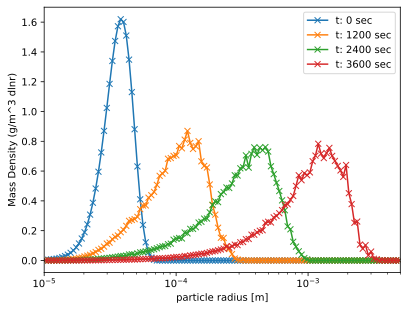

In [7]:
for step, output in pysdm_output.items():
    if step*PLOT_TIME_STEP%1200!=0:
        continue
    plt.plot(
        ((radius_bins_edges[1:] + radius_bins_edges[:-1]) / 2),
        output,
        label=f"t: {step*PLOT_TIME_STEP} sec",
        marker='x'
    )
plt.xscale("log")

if BINNING_METHOD == 'Number Concentration (m^-3)':
    plt.yscale("log")
    plt.ylim([1e2,5e10])
plt.ylabel(BINNING_METHOD)
plt.xlim([R_BINS_MIN,R_BINS_MAX])
plt.xlabel("particle radius [m]")
plt.legend()

show_plot()

In [8]:
gas_data = ppmc.GasData(("H2SO4","HNO3","HCl","NH3","NO","NO2"))

In [9]:
env_state = ppmc.EnvState(
    {
        "rel_humidity": AMBIENT_RH,
        "latitude": 40,
        "longitude": 0,
        "altitude": 0 * ppmc.si.m,
        "start_time": 0 * ppmc.si.s,
        "start_day": 1,
        "additive_kernel_coefficient": ADDITIVE_KERNEL_COEFF,
    }
)

In [10]:
aero_data = ppmc.AeroData(
    (
        {"H2O": [1000 * ppmc.si.kg / ppmc.si.m**3, 0, 18.0 * ppmc.si.g / ppmc.si.mol, 0.00]},
    )
)

In [11]:
gas_state = ppmc.GasState(gas_data)

In [12]:
times = [0 * ppmc.si.s]
back_gas = [{"time": times},
            {"rate": [0 / ppmc.si.s]},
            {"NO": [0.0E+00]},
           ]

gas_emit_times = [0]

gas_emit_rates = np.ones(len(gas_emit_times))

emit_gas = [
    {"time": gas_emit_times},
    {"rate": list(gas_emit_rates)},
    {"NO": [0]},
]

AERO_DIST_BACKGROUND = {
    "back_small": {
        "mass_frac": [{"H2O": [1]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 0 / ppmc.si.m**3,
        "geom_mean_diam": 0.02 * ppmc.si.um,
        "log10_geom_std_dev": 0.161,
    },
}

AERO_DIST_EMIT = {
    "gasoline": {
        "mass_frac": [{"H2O": [1.0]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 0 / ppmc.si.m**3,
        "geom_mean_diam": 5e-8 * ppmc.si.m,
        "log10_geom_std_dev": 0.24,
    },
}

In [13]:
time_timeseries = [0]
pressure_timeseries = [AMBIENT_P_Pa * ppmc.si.Pa]
temp_timeseries = [AMBIENT_T_K * ppmc.si.K]
height_timeseries = [1000]

In [14]:
scenario = ppmc.Scenario(
    gas_data,
    aero_data,
    {
        "temp_profile": [{"time": time_timeseries}, {"temp": temp_timeseries}],
        "pressure_profile": [
            {"time": time_timeseries},
            {"pressure": pressure_timeseries},
        ],
        "height_profile": [{"time": time_timeseries}, {"height": height_timeseries}],
        "gas_emissions": emit_gas,
        "gas_background": back_gas,
        "aero_emissions": [
            {"time": [0 * ppmc.si.s]},
            {"rate": [0 / ppmc.si.s]},
            {"dist": [[AERO_DIST_EMIT]]},
        ],
        "aero_background": [
            {"time": [0 * ppmc.si.s]},
            {"rate": [0 / ppmc.si.s]},
            {"dist": [[AERO_DIST_BACKGROUND]]},
        ],
        "loss_function": "none",
    },
)

In [15]:
T_INITIAL = 0.0
scenario.init_env_state(env_state, T_INITIAL)

In [16]:
AERO_DIST_INIT = [
    {
        "init1": {
            "mass_frac": [{"H2O": [1]}],
            "diam_type": "geometric",
            "mode_type": "exp",
            "num_conc": NUM_CONC_PER_M3 / ppmc.si.m**3,
            "diam_at_mean_vol": DIAM_AT_MEAN_VOL_M * ppmc.si.m,
        },
    }
]

aero_dist_init = ppmc.AeroDist(aero_data, AERO_DIST_INIT)

In [17]:
run_part_opt = ppmc.RunPartOpt(
    {
        "output_prefix": 'additive',
        "do_coagulation": True,
        "coag_kernel": "additive",
        "t_max": T_MAX_SEC * ppmc.si.s,
        "del_t": DT_SEC * ppmc.si.s,
    }
)

aero_state = ppmc.AeroState(aero_data, N_PART, "flat")
aero_state.dist_sample(aero_dist_init)

65338

In [18]:
camp_core = ppmc.CampCore()
photolysis = ppmc.Photolysis()

In [19]:
N_STEPS = int(run_part_opt.t_max / run_part_opt.del_t)
num_conc = np.zeros(N_STEPS + 1)
num_conc[0] = aero_state.total_num_conc
mass_conc = np.zeros(N_STEPS + 1)
mass_conc[0] = aero_state.total_mass_conc
time = np.zeros(N_STEPS + 1)
gas_mix_rat = np.zeros((N_STEPS + 1, gas_state.n_spec))
gas_mix_rat[0, :] = gas_state.mix_rats

height = np.zeros((N_STEPS + 1))
temperature = np.zeros((N_STEPS + 1))
rh = np.zeros((N_STEPS + 1))

height[0] = env_state.height
temperature[0] = env_state.temp
rh[0] = env_state.rh

diam_grid = ppmc.BinGrid(N_BINS, "log", (R_BINS_MIN)*2, (R_BINS_MAX)*2)
rad_grid = ppmc.BinGrid(N_BINS, "log", R_BINS_MIN, R_BINS_MAX)
dists = []
diameters = aero_state.diameters()
num_concs = aero_state.num_concs
masses = aero_state.masses()
mass_concs = np.array(num_concs) * np.array(masses)
dists_mass = []
dists_dmlnr = []
dists.append(ppmc.histogram_1d(rad_grid, np.array(diameters)/2, num_concs))
dists_mass.append(ppmc.histogram_1d(rad_grid, np.array(diameters)/2, mass_concs / ppmc.si.g))

for i_time in range(1,N_STEPS + 1):
    ppmc.run_part_timestep(
        scenario,
        env_state,
        aero_data,
        aero_state,
        gas_data,
        gas_state,
        run_part_opt,
        camp_core,
        photolysis,
        i_time,
        T_INITIAL,
    )
    num_conc[i_time] = aero_state.total_num_conc
    mass_conc[i_time] = aero_state.total_mass_conc
    time[i_time] = env_state.elapsed_time
    gas_mix_rat[i_time, :] = gas_state.mix_rats
    height[i_time] = env_state.height
    temperature[i_time] = env_state.temp
    rh[i_time] = env_state.rh
    
    if np.mod(i_time * run_part_opt.del_t, PLOT_TIME_STEP) == 0:
        diameters = aero_state.diameters()
        num_concs = aero_state.num_concs
        masses = aero_state.masses()
        mass_concs = np.array(num_concs) * np.array(masses)
        dists.append(ppmc.histogram_1d(rad_grid, np.array(diameters)/2, num_concs))
        dists_mass.append(ppmc.histogram_1d(rad_grid, np.array(diameters)/2, mass_concs / ppmc.si.g))

if BINNING_METHOD == 'Number Concentration (m^-3)':
    PyPartDists = dists
elif BINNING_METHOD == 'Mass Density (g/m^3 dlnr)':   
    PyPartDists = dists_mass


In [20]:
plt.rcParams.update({'font.size': 9})
plt.rcParams.update({'figure.figsize': (7.08,4.5)})
plt.rcParams.update({"axes.grid" : True})

In [21]:
def set_tickmarks(axes, n_ticks):
    ylims = axes.get_ylim()
    if np.log10(ylims[0]) > 1:
        val = -int(np.ceil(np.abs(np.log10(ylims[0])))) + 1
    else:
        val = int(np.ceil(np.abs(np.log10(ylims[0])))) + 1     
    ymin = round(ylims[0] - .1 * ylims[0], val)
    ymax = round(ylims[1] + .1 * ylims[1], val)
    plt.ylim([ymin, ymax])
    plt.yticks(np.linspace(ymin, ymax, n_ticks))

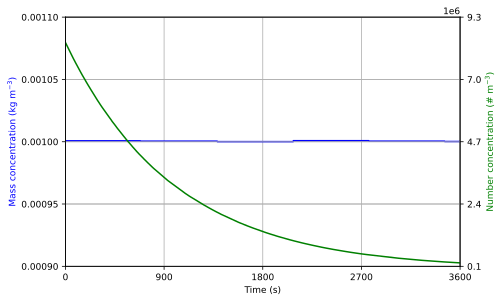

In [22]:
plt.plot(time, mass_conc, "b", label="mass conc")
plt.ylabel("Mass concentration (kg m$^{-3}$)", color='b')
plt.xlabel("Time (s)")
set_tickmarks(plt.gca(), 5)
plt.twinx()
plt.plot(time, num_conc, "g", label="num conc")
plt.xticks(np.linspace(0, time[-1], 5))
plt.xlim([time[0],time[-1]])
plt.ylim([min(num_conc)/2,max(num_conc)*1.01])
set_tickmarks(plt.gca(), 5)
plt.ylabel(r"Number concentration ($\#$ m$^{-3}$)", color='g')
show_plot()

In [23]:
BASE_URL = (
    # replace main with commit id for previous commit
    'https://raw.githubusercontent.com/emmacware/Droplets.jl/refs/heads/dev/' 
)
for path in (
    'Examples/testfunctions.jl', 'Examples/DSDvis.jl','src/SDfunc/coalescence.jl'
):
    print(path)
    with open('Droplets.jl-' + path.replace('/','-'), 'w', encoding='utf-8') as fout:
        with urllib.request.urlopen(BASE_URL + path) as fin:
            fout.write(fin.read().decode('utf-8'))

Examples/testfunctions.jl
Examples/DSDvis.jl
src/SDfunc/coalescence.jl


In [24]:
SETUP = {
    "n_0": NUM_CONC_PER_M3,
    "Ns": N_PART,
    "V": VOLUME_M3,
    "dt": DT_SEC,
    "t_max": T_MAX_SEC,
    "d_mean": DIAM_AT_MEAN_VOL_M,
    "b": ADDITIVE_KERNEL_COEFF,
    "num_bins" : N_BINS,
    "num_bin_edges": N_BIN_EDGES,
    "radius_bins_log_low":R_BINS_MIN, 
    "radius_bins_log_high":R_BINS_MAX,
    "smooth": False,
    "smooth_scope": 2,
    "init_random_seed": 30,
    "coag_threading": "Serial()",
    "output_steps": list(range(0, T_MAX_SEC + PLOT_TIME_STEP, PLOT_TIME_STEP)),
    "init_method": "init_ξ_const",
    "binning_method": BINNING_METHOD,
}


with open('setup.json', 'w', encoding='UTF-8') as f:
    json.dump(SETUP, f)

In [25]:
%%writefile script.jl

using Pkg
Pkg.add(["Combinatorics","Distributions","Random","JSON","DelimitedFiles","CPUTime"])
using Random
using Combinatorics
using Distributions
using CPUTime
include("Droplets.jl-src-SDfunc-coalescence.jl")
include("Droplets.jl-Examples-DSDvis.jl")
include("Droplets.jl-Examples-testfunctions.jl")
using DelimitedFiles
using JSON

    
FT = Float64
setup = JSON.parsefile("./setup.json")



Ns::Int = setup["Ns"]
FT = Float64
num_bins::Int = setup["num_bins"]
radius_bins_edges = 10 .^ range(log10(setup["radius_bins_log_low"]), log10(setup["radius_bins_log_high"]), length=setup["num_bin_edges"]) 
R0 = FT(setup["d_mean"])/2

if setup["binning_method"] == "Number Concentration (m^-3)"
        binning_method = number_density
elseif setup["binning_method"] == "Mass Density (g/m^3 dlnr)"
        binning_method = mass_density_lnr
end


coagsettings = coag_settings{FT}(Ns=Ns,Δt=setup["dt"],ΔV=setup["V"],
        golovin_kernel_coeff=FT(setup["b"]), n0=FT(setup["n_0"]),R0=R0)

runsettings=run_settings{FT}(num_bins=num_bins,radius_bins_edges=radius_bins_edges,
        smooth=setup["smooth"],coag_threading=eval(Meta.parse(setup["coag_threading"])),
        output_steps=setup["output_steps"],init_method=eval(Meta.parse(setup["init_method"])),binning_method = binning_method)

drops = runsettings.init_method(coagsettings)
bin,timing = coag_runtime(1,drops,coagsettings,runsettings)


json_string = JSON.json(bin)

open("output.json", "w") do file
    write(file, json_string)
end

println("output written to output.json")

Overwriting script.jl


In [26]:
subprocess.run(["julia", "script.jl"], check=True)


The latest version of Julia in the `release` channel is 1.11.2+0.aarch64.apple.darwin14. You currently have `1.10.4+0.aarch64.apple.darwin14` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.2+0.aarch64.apple.darwin14 and update the `release` channel to that version.
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


Running simulation...
simtime =2.814713
coal_func_time =2.5472279999999996
output written to output.json


CompletedProcess(args=['julia', 'script.jl'], returncode=0)

In [27]:
with open('output.json', 'r', encoding='utf8') as file:
    Droplets = json.load(file)

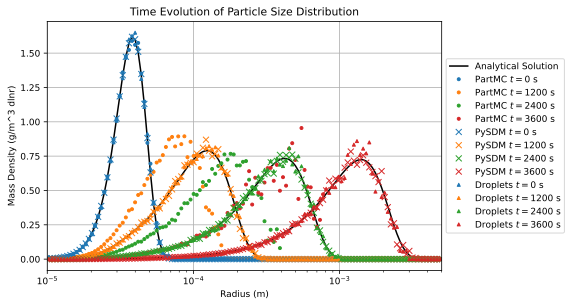

In [28]:
cs = []
# t = list(range(0, T_MAX_SEC + PLOT_TIME_STEP, PLOT_TIME_STEP))
t = np.divide(np.array(range(0, int(T_MAX_SEC+1), 1200)),PLOT_TIME_STEP).astype(int)
analytical_times = np.array([1e-10,1200,2400,3600])

for i_time, t_sec in enumerate(analytical_times):
    if i_time == 0:
        plt.plot(np.array(rad_grid.centers),analytical_solution_golovin(t_sec),label='Analytical Solution',c='k')
    else:
        plt.plot(np.array(rad_grid.centers),analytical_solution_golovin(t_sec),c='k')



for i_time, t_sec in enumerate(t):
    p = plt.plot(np.array(rad_grid.centers), PyPartDists[t_sec],'o',label=f'PartMC $t = {t_sec*PLOT_TIME_STEP}$ s',
           ms=3)
    cs.append(p[0].get_color())
    
for i_time,t_sec in enumerate(t):
    plt.plot((radius_bins_edges[1:] + radius_bins_edges[:-1])/2,
        pysdm_output[t_sec],
             'x', label=f'PySDM $t = {t_sec*PLOT_TIME_STEP}$ s', c=cs[i_time])
    
for i_time,t_sec in enumerate(t):
    plt.plot((radius_bins_edges[1:] + radius_bins_edges[:-1])/2,
        np.asarray(Droplets[t_sec]),
        '^', label=f'Droplets $t = {t_sec*PLOT_TIME_STEP}$ s',ms=3,
            c=cs[i_time])

plt.xscale("log")
plt.xlabel("Radius (m)")
plt.ylabel(BINNING_METHOD)
if BINNING_METHOD == 'Number Concentration (m^-3)':
    plt.yscale("log")
    plt.ylim([1e2,5e10])
plt.xlim([R_BINS_MIN,R_BINS_MAX])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Time Evolution of Particle Size Distribution")
plt.savefig('units.pdf', bbox_inches='tight')

show_plot()

/Users/emmaware/Library/Python/3.9/lib/python/site-packages/PySDM/dynamics/collisions/collision_kernels/golovin.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  (1 - tau)
/Users/emmaware/Library/Python/3.9/lib/python/site-packages/PySDM/dynamics/collisions/collision_kernels/golovin.py:38: RuntimeWarning: invalid value encountered in scalar multiply
  (1 - tau)



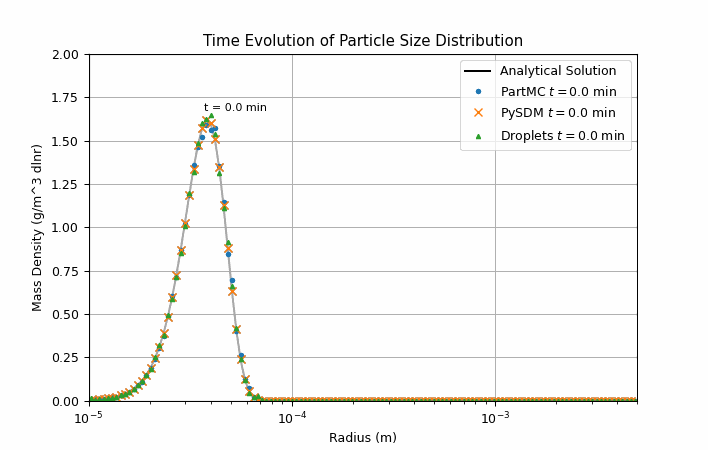

HTML(value="<a href='./tmpzcyrblzu.gif' target='_blank'>./tmpzcyrblzu.gif</a><br>")

In [29]:
def anim_func(frame):
    # fig = plt.figure(figsize=(9,6))
    # ax = fig.add_subplot(111)
    if frame > T_MAX_SEC/PLOT_TIME_STEP:
        frame = int(T_MAX_SEC/PLOT_TIME_STEP)

    t = list(range(0, int((frame+1)*PLOT_TIME_STEP), 1200))
    plt.plot(np.array(rad_grid.centers),analytical_solution_golovin(1e-10),c='darkgray')
    for i_time, t_sec in enumerate(t):
        step = int(t_sec/PLOT_TIME_STEP)
        plt.plot(np.array(rad_grid.centers),analytical_solution_golovin(t_sec),c='darkgray')
        plt.plot(np.array(rad_grid.centers), PyPartDists[step],'o',# linestyle='-', linewidth=0.5,
            c='grey',
            ms=2)
        plt.plot((radius_bins_edges[1:] + radius_bins_edges[:-1])/2,
            pysdm_output[step],'x',c='grey'),# linestyle='-', linewidth=0.5
                # label=False)
        plt.plot((radius_bins_edges[1:] + radius_bins_edges[:-1])/2,
            np.asarray(Droplets[step]),'^',c='grey',# linestyle='-', linewidth=0.5, 
            ms=1)
        idx = PyPartDists[step].index(max(PyPartDists[step]))
        text_height = 1.05*max(PyPartDists[step])
        plt.text(radius_bins_edges[idx], text_height, f't = {t_sec/60} min', fontsize=8)


    plt.plot(np.array(rad_grid.centers),analytical_solution_golovin(frame*PLOT_TIME_STEP),label='Analytical Solution',c='k')

    plt.plot(np.array(rad_grid.centers), PyPartDists[frame],'o',# linestyle='-', linewidth=0.5,
             label=f'PartMC $t = {frame*PLOT_TIME_STEP/60}$ min',
           ms=3)
    plt.plot((radius_bins_edges[1:] + radius_bins_edges[:-1])/2,
        pysdm_output[frame],'x',# linestyle='-', linewidth=0.5,
             label=f'PySDM $t = {frame*PLOT_TIME_STEP/60}$ min')
    plt.plot((radius_bins_edges[1:] + radius_bins_edges[:-1])/2,
        np.asarray(Droplets[frame]),'^',# linestyle='-', linewidth=0.5, 
        label=f'Droplets $t = {frame*PLOT_TIME_STEP/60}$ min',ms=3)
    
    plt.xscale("log")
    plt.xlabel("Radius (m)")
    plt.ylabel(BINNING_METHOD)
    if BINNING_METHOD == 'Number Concentration (m^-3)':
        plt.yscale("log")
        plt.ylim([1e2,5e10])
    plt.ylim([0,2])
    plt.xlim([R_BINS_MIN,R_BINS_MAX])
    plt.legend(loc='upper right')#, bbox_to_anchor=(1, 0.5))
    plt.title("Time Evolution of Particle Size Distribution")
    return plt.gcf()


frame_range = range(0,int(T_MAX_SEC/PLOT_TIME_STEP)+10,1)
show_anim(anim_func, frame_range)

In [ ]:
#TODO: add assert on match with analytical solution

